# Домашняя работа 7. Работа с категориальными признаками. ##

### Оценивание и штрафы

Максимальная оценка — 10 баллов.

Не списывайте, иначе всем участникам обнулим :)

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка: 10**

In [348]:
print('Всем удачи!👒')

Всем удачи!👒


In [349]:
from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [350]:
from sklearn.model_selection import train_test_split

In [351]:
import warnings
warnings.filterwarnings('ignore')

In [352]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

## Работа с категориальными признаками (10 баллов)

Сейчас мы научимся обрабатывать категориальные переменные. Как вы уже знаете, закодировать их в виде столбика чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть, но модель попробует его выучить). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Подготовка данных.__

Загрузим данные [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о маркетинговой кампании какого-то банка, объектом в нем является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит), целевой переменной — ответ клиента (согласился ли он открыть депозит?). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы — более подробная информация на страничке с датасетом.

In [353]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

In [354]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


__Задание 1 (2 балла).__ Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, укажите значение параметра `stratify`. Один из столбцов (помимо таргета :) ) стоит сразу выкинуть из обучающей выборки. Какой? Не отказывайте себе.



Выберем категориальные признаки и посмотрим, как распрелены значения в этих признаках. Здесь я частично использовал код с StackOverflow (https://stackoverflow.com/questions/70811240/finding-frequency-of-each-value-in-all-categorical-columns-across-a-dataframe)

In [355]:
cat_features = df.columns[df.dtypes == "object"]
cat_features

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'y'],
      dtype='object')

In [356]:
frequencies = (df[cat_features].select_dtypes(object)
       .melt(var_name="Column", value_name="Variable")
       .value_counts(dropna=False)
       .reset_index(name="Frequency")
       .sort_values(by=['Column','Frequency','Variable'], ascending=[True,False,True])
       .reset_index(drop=True))
frequencies

,Column,Variable,Frequency
0,contact,cellular,26144
1,contact,telephone,15044
2,day_of_week,thu,8623
3,day_of_week,mon,8514
4,day_of_week,wed,8134
5,day_of_week,tue,8090
6,day_of_week,fri,7827
7,default,no,32588
8,default,unknown,8597
9,default,yes,3


Видим, что поле default большую часть времени принимает значения `no` или `unknown`, и только 3 раза `yes`. То есть с большой вероятностью оно не несет какой-то информации. Его и выкинем. Таргет выкинем на этапе разделения выборки.

In [357]:
df.drop(["default"], inplace=True, axis=1, errors="ignore")
df

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [358]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1].to_numpy(), df.loc[:, "y"].to_numpy(), test_size=0.25, random_state=777)
X_train

array([[32, 'services', 'single', ..., -42.7, 4.957, 5228.1],
       [45, 'management', 'married', ..., -36.4, 4.857, 5191.0],
       [47, 'management', 'married', ..., -42.0, 4.12, 5195.8],
       ...,
       [59, 'retired', 'married', ..., -40.8, 1.26, 5076.2],
       [35, 'entrepreneur', 'married', ..., -38.3, 0.89, 4991.6],
       [33, 'blue-collar', 'married', ..., -42.7, 4.96, 5228.1]],
      dtype=object)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c `AUC-PR`) при применении логистической регрессии. Здесь и далее для реализации последовательности этих действий (обработка признаков + обучение модели) используйте пайплайны. Замерьте время, потребовавшееся на обучение модели (с учетом кодирования признаков).

__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ваш ответ__: 
Во-первых, у нас несбалансированный датасет, поэтому если модель будет всегда (или очень часто) предсказывать наибольший класс, AUC-ROC будет высоким, хотя модель не особо качественная

https://www.quora.com/Why-is-precision-recall-a-better-metric-than-AUC-for-unbalanced-data

https://stats.stackexchange.com/questions/360017/when-is-an-auc-score-misleadingly-high

Во-вторых, значение AUC-ROC зависит от сортировки категориалных признаков. Если мы обучили модель и получили низкий (ниже 0.5) AUC-ROC, то мы можем изменить порядок сортировки всех признаков и получить противоположный результат больше 0.5. Более того, мы можем перебрать все возможные перестановки значений, тем самым получив наиболее высокий AUC-ROC. Это говорит о том, что AUC-ROC некорректно отражает качество модели и зависит от порядка сортировки. С AUC-PR такой проблемы нет, так как если модель смещена в сторону одного класса, растет `precision` за счет уменьшения числа `False Positive`, то падает `recall` за счет увеличения `False Negative`, или наоборот. В итоге на положение точки на графике это не влияет. Здесь мы используем `Ordinal Encoding`, поэтому проблема релевантна.

https://stats.stackexchange.com/questions/563566/validity-of-auc-for-binary-categorical-variables

Далее я для примера буду выводить также `AUC ROC`, он всегда будет на уровне около `0.7`, что как будто хорошо, а вот `AUC PR` будет меньше `0.5` (хуже чем рандомная модель с вероятностью класса 1 равной доле этого класса).

0.1738130000885576 seconds elapsed
AUC PR: 0.3000623593498663
AUC ROC: 0.6555335682202528


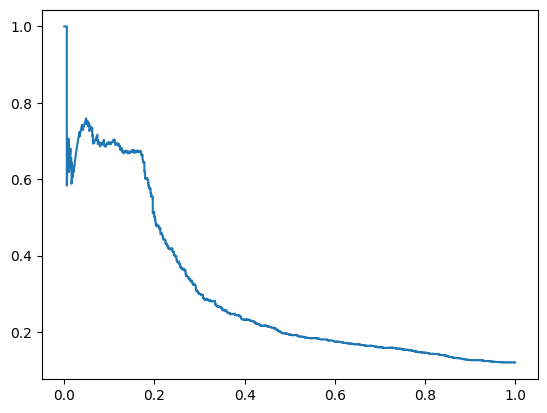

In [359]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from time import perf_counter

cat_features_indices = df.dtypes == "object" #will initialize again as we have dropped "default"

start = perf_counter()
pipe1_oe = Pipeline([("ordinal ecnoder", ColumnTransformer([('ordinal encoder', OrdinalEncoder(), cat_features_indices[:-1])])), 
                     ("logistic regression", LogisticRegression())])

pipe1_oe.fit(X_train, y_train)
y_pred_proba = pipe1_oe.predict_proba(X_test)[:, 1]
end = perf_counter()
print(f"{end-start} seconds elapsed")

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba, pos_label="yes")
AUC_PR = auc(recall, precision)
AUC_ROC = roc_auc_score(y_test, y_pred_proba)
print(f"AUC PR: {AUC_PR}\nAUC ROC: {AUC_ROC}")
plt.plot(recall, precision)

Видим, что `AUC ROC` больше, как и ожидалось.

__Задание 2 (2 балла).__ Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели. Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.



0.28975940006785095 seconds elapsed
AUC PR: 0.40820383445096037
AUC ROC: 0.7396561243372963


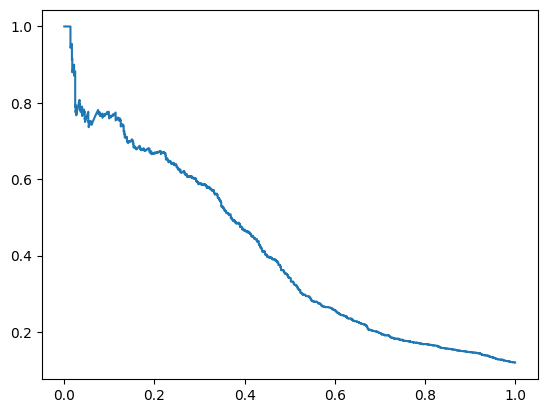

In [360]:
from sklearn.preprocessing import OneHotEncoder

pipe2_onehot = Pipeline([("onehot encoder", ColumnTransformer([('onehot encoder', OneHotEncoder(), cat_features_indices[:-1])])), 
                     ("logistic regression", LogisticRegression())])

start=perf_counter()
pipe2_onehot.fit(X_train, y_train)
y_pred_proba = pipe2_onehot.predict_proba(X_test)[:, 1]
end = perf_counter()
print(f"{end-start} seconds elapsed")

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba, pos_label="yes")
AUC_PR = auc(recall, precision)
AUC_ROC = roc_auc_score(y_test, y_pred_proba)
print(f"AUC PR: {AUC_PR}\nAUC ROC: {AUC_ROC}")
plt.plot(recall, precision)

Время увеличилось примерно в 1.5 раза, но и качество выросло. В целом это ожидаемо, так как мы не упорядочивали переменные, а в реальности их сложно разумно упорядочить.

Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков в датасете, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирования категориальных признаков — счётчики. Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 3 (2 балла).__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков). Заметили ли вы что-то интересное?

Нам нельзя использовать `Target Encoding` из `sklearn`, так как там по умолчанию проводится "хитрости" которые нельзя отключить (на выходе матрица признаков не получается такой, как нужно). Также пайплайны не позволяют адеквартно произвести `Target Encoding` на тестовой выборке, так как метод `predict_proba` не принимает на вход `y`, а наш энкодер его требует. Поэтому я вручную преобразовал данные в коде.

4.3100058999843895 seconds elapsed
On test
AUC PR: 0.404062121249995
AUC ROC: 0.7420648090305859
On train
AUC PR: 0.3781378469662501
AUC ROC: 0.7511306109745485


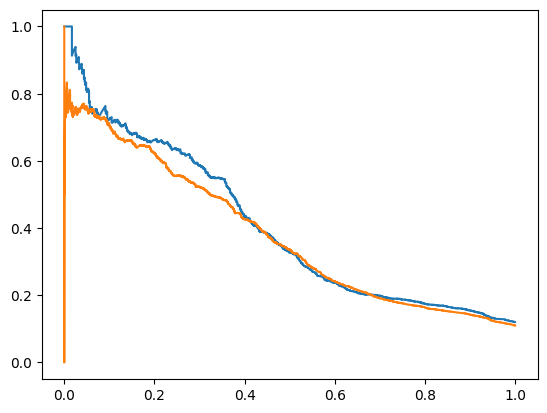

In [361]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import TargetEncoder

class SimpleTargetEncoder:
    '''
    Custom encoder class similar to TargetEncoder from sklearn
    '''
    def __init__(self, features_indices=None):
        self.features_indices = features_indices


    def fit(self, X, y):
        return self
    

    def transform(self, X, y):
        if self.features_indices is None:
            X = X.copy()
        else:
            X = X[:, self.features_indices].copy()
        for column in range(X.shape[1]):
            for value in np.unique(X[:, column]):
                X[X[:, column] == value, column] = y[X[:, column] == value].mean()
        return X
    

    def fit_transform(self, X, y):
        return self.transform(X, y)

pipe3_target = Pipeline([("lr", LogisticRegression())]) #data preparation is external here

y_train = (np.logical_or(y_train == "yes", y_train == 1)).astype(int) #converting labels to 0 and 1 as out encoder cannot deal with custom labels automatically 
y_test = (np.logical_or(y_test == "yes", y_test == 1)).astype(int)

start=perf_counter()

t_encoder = SimpleTargetEncoder(features_indices=cat_features_indices[:-1])

pipe3_target.fit(t_encoder.transform(X_train, y_train), y_train)

y_pred_proba = pipe3_target.predict_proba(t_encoder.transform(X_test, y_test))[:, 1]

end = perf_counter()
print(f"{end-start} seconds elapsed")

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

AUC_PR = auc(recall, precision)
AUC_ROC = roc_auc_score(y_test, y_pred_proba)
print(f"On test\nAUC PR: {AUC_PR}\nAUC ROC: {AUC_ROC}")

y_pred_proba_train = pipe3_target.predict_proba(t_encoder.transform(X_train, y_train))[:, 1] #also measuring metrics on train sample to see if overfitting occurs
precision_train, recall_train, _ = precision_recall_curve(y_train, y_pred_proba_train)
AUC_PR = auc(recall_train, precision_train)
AUC_ROC = roc_auc_score(y_train, y_pred_proba_train)
print(f"On train\nAUC PR: {AUC_PR}\nAUC ROC: {AUC_ROC}")

plt.plot(recall, precision)
plt.plot(recall_train, precision_train)

Времени, конечно, ушло намного больше, так как пришлось использовать свою функцию с питоновским `for`, который работает медленно. Не сказал бы, что модель переобучилась, как это предполагается далее, метрики остались в целом такими же, как с `OneHot Encoding`. Если бы функционал `sklearn` позволял проводить кодирование в пайплайне и была встроенная функция, производящая самое простое кодирование по формуле выше, можно было бы оценить скорость работы (изначально пробовал с `TargetEncoding` из `sklearn`, время и резльтат были примерно такими же как у `OneHot Encoding`).

Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем «утечку» целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении счетчика для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Вносить шум в посчитанные признаки.

__Задание 4 (2 балла).__ Реализуйте корректное вычисление счётчиков самым простым способом — добавлением шума к значениям (постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.
Какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием можно отметить?

Добавим параметр `noise_level` в наш класс и аналогично обучим модель

In [362]:
class SimpleTargetEncoder:
    '''
    Custom encoder class similar to TargetEncoder from sklearn
    '''
    def __init__(self, features_indices=None, noise_level=0):
        self.features_indices = features_indices
        self.noise_level=noise_level


    def fit(self, X, y):
        return self
    

    def transform(self, X, y):
        if self.features_indices is None:
            X = X.copy()
        else:
            X = X[:, self.features_indices].copy()
        for column in range(X.shape[1]):
            for value in np.unique(X[:, column]):
                X[X[:, column] == value, column] = y[X[:, column] == value].mean()
            X[:, column] += self.noise_level * np.random.uniform(-1, 1, size=X.shape[0])
        return X
    

    def fit_transform(self, X, y):
        return self.transform(X, y)

4.377054000040516 seconds elapsed
On test
AUC PR: 0.39964947259051076
AUC ROC: 0.7389061940204951
On train
AUC PR: 0.37375715518609864
AUC ROC: 0.7455559424346939


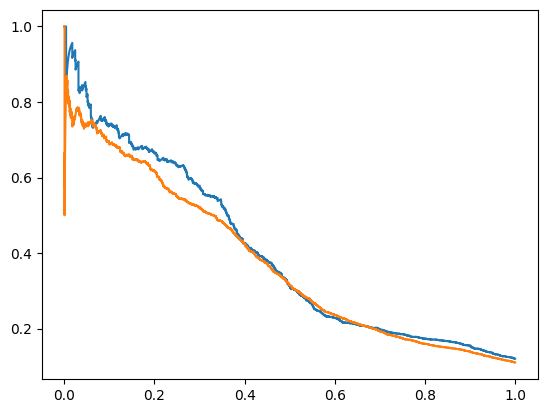

In [363]:
start=perf_counter()

t_encoder = SimpleTargetEncoder(features_indices=cat_features_indices[:-1], noise_level=0.03)

pipe3_target.fit(t_encoder.transform(X_train, y_train), y_train)

y_pred_proba = pipe3_target.predict_proba(t_encoder.transform(X_test, y_test))[:, 1]

end = perf_counter()
print(f"{end-start} seconds elapsed")

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

AUC_PR = auc(recall, precision)
AUC_ROC = roc_auc_score(y_test, y_pred_proba)
print(f"On test\nAUC PR: {AUC_PR}\nAUC ROC: {AUC_ROC}")

y_pred_proba_train = pipe3_target.predict_proba(t_encoder.transform(X_train, y_train))[:, 1] #also measuring metrics on train sample to see if overfitting occurs
precision_train, recall_train, _ = precision_recall_curve(y_train, y_pred_proba_train)
AUC_PR = auc(recall_train, precision_train)
AUC_ROC = roc_auc_score(y_train, y_pred_proba_train)
print(f"On train\nAUC PR: {AUC_PR}\nAUC ROC: {AUC_ROC}")

plt.plot(recall, precision)
plt.plot(recall_train, precision_train)

У нас и так не было переобучения, поэтому устранить его не удалось)) Получилось, что чем меньше уровень шума, тем лучше качество (в идеале, наверное, тестовые данные не зашумлять, но даже на обучающей выборке качество падает).

Для сравнение посмотрим на результаты с `TargetEncoder` из `sklearn`

0.24595819995738566 seconds elapsed
AUC PR: 0.3971059127326719
AUC ROC: 0.7406559868433841


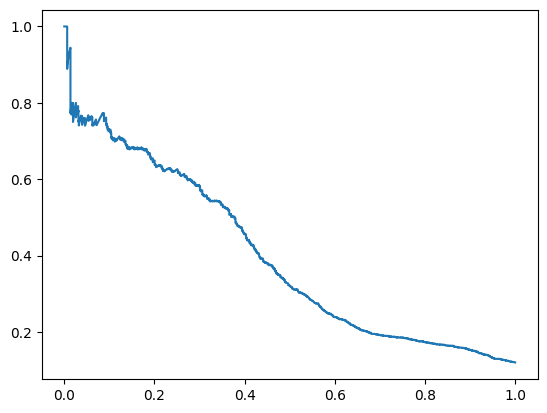

In [364]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1].to_numpy(), df.loc[:, "y"].to_numpy(), test_size=0.25, random_state=777)

pipe4_nativete = Pipeline([("target encoder", ColumnTransformer([('target encoder', TargetEncoder(), cat_features_indices[:-1])])), 
                     ("logistic regression", LogisticRegression())])

start=perf_counter()
pipe4_nativete.fit(X_train, y_train)
y_pred_proba = pipe4_nativete.predict_proba(X_test)[:, 1]
end = perf_counter()
print(f"{end-start} seconds elapsed")

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba, pos_label="yes")
AUC_PR = auc(recall, precision)
AUC_ROC = roc_auc_score(y_test, y_pred_proba)
print(f"AUC PR: {AUC_PR}\nAUC ROC: {AUC_ROC}")
plt.plot(recall, precision)

Как видим, качество не сильно лучше, но время меньше.

Далее будем использовать `TargetEncoder`, чтобы было показательнее.

__Задание 5 (2 балла).__ В данных имеется признак «возраст клиента». Сейчас мы интерпретируем его как числовой, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этого признака есть довольно много уникальных значений (сколько?), поэтому применять к нему one-hot кодирование может оказаться излишним. Попробуйте закодировать возраст с помощью счетчиков. Стало ли лучше?



In [365]:
print(len(df['age'].unique()))

78


Имеем 78 различных значений для возраста. Добавим этот признак к категориальным и аналогично обучим модель

0.24978339998051524 seconds elapsed
AUC PR: 0.4010389841946759
AUC ROC: 0.7443457634844345


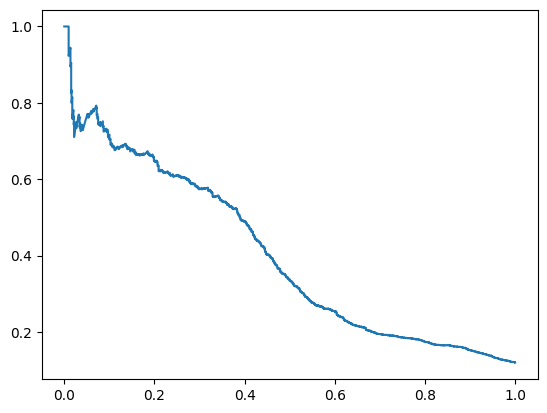

In [366]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1].to_numpy(), df.loc[:, "y"].to_numpy(), test_size=0.25, random_state=777)

cat_features_indices["age"] = True

pipe5 = Pipeline([("target encoder", ColumnTransformer([('target encoder', TargetEncoder(), cat_features_indices[:-1])])), 
                     ("logistic regression", LogisticRegression())])

start=perf_counter()
pipe5.fit(X_train, y_train)
y_pred_proba = pipe5.predict_proba(X_test)[:, 1]
end = perf_counter()
print(f"{end-start} seconds elapsed")

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba, pos_label="yes")
AUC_PR = auc(recall, precision)
AUC_ROC = roc_auc_score(y_test, y_pred_proba)
print(f"AUC PR: {AUC_PR}\nAUC ROC: {AUC_ROC}")
plt.plot(recall, precision)

Стало немного лучше, но не особо (что логично, возраст больше смысла имеет как численный признак)

Можно пойти и в обратную сторону. У нас есть признаки «месяц и день недели» для звонка. Попробуйте интерпретировать их как числовые (месяц от 0 до 12, дни недели от 0 до 4). Стало ли лучше в этот раз?

In [367]:
monthsmap = {month: index for index, month in enumerate(['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])}
daysmap = {day: index for index, day in enumerate(['mon', 'tue', 'wed', 'thu', 'fri'])}

for month, value in monthsmap.items():
    df.loc[df.loc[:, "month"] == month, "month"] = value

for day, value in daysmap.items():
    df.loc[df.loc[:, "day_of_week"] == day, "day_of_week"] = value

df

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,telephone,4,0,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,no,no,telephone,4,0,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,yes,no,telephone,4,0,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,telephone,4,0,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,yes,telephone,4,0,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,yes,no,cellular,10,4,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,cellular,10,4,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,yes,no,cellular,10,4,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,cellular,10,4,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


0.18819939997047186 seconds elapsed
AUC PR: 0.34700177442223096
AUC ROC: 0.7099545414096533


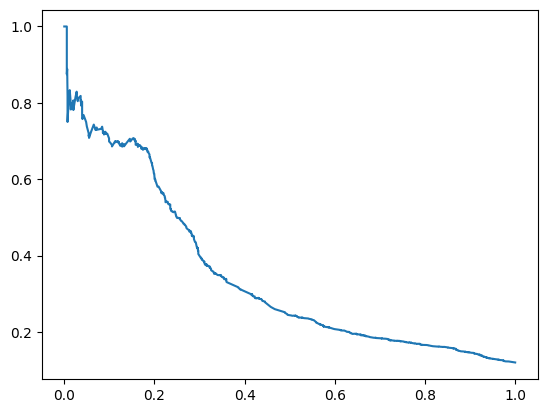

In [368]:

cat_features_indices["age"] = False
cat_features_indices["day_of_week"] = False
cat_features_indices["month"] = False

X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1].to_numpy(), df.loc[:, "y"].to_numpy(), test_size=0.25, random_state=777)

pipe5 = Pipeline([("target encoder", ColumnTransformer([('target encoder', TargetEncoder(), cat_features_indices[:-1])])), 
                     ("logistic regression", LogisticRegression())])

start=perf_counter()
pipe5.fit(X_train, y_train)
y_pred_proba = pipe5.predict_proba(X_test)[:, 1]
end = perf_counter()
print(f"{end-start} seconds elapsed")

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba, pos_label="yes")
AUC_PR = auc(recall, precision)
AUC_ROC = roc_auc_score(y_test, y_pred_proba)
print(f"AUC PR: {AUC_PR}\nAUC ROC: {AUC_ROC}")
plt.plot(recall, precision)

Тоже лучше не стало, стало только хуже (что логично, месяц больше смысла имеет как категориальный признак)